In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from timeit import default_timer as timer  #for checking run time
from datetime import timedelta
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import callbacks
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from keras import models
from keras import layers
pd.options.mode.chained_assignment = None
from nltk.tokenize import word_tokenize
import nltk
#nltk.download('punkt')

In [2]:
df = pd.read_csv("The-Office-Lines-V2.csv")
print(f"dataset has {df.columns.shape[0]} columns \ndataset has {df.shape[0]} rows")
df.head(3)

dataset has 6 columns 
dataset has 54167 rows


,season,episode,title,scene,speaker,line
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...
1,1,1,Pilot,1,Jim,"Oh, I told you. I couldn't close it. So..."
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...


In [3]:
mostchar=df.groupby(by="speaker",sort=False).agg({"speaker":"count"}).rename_axis("index").sort_values(by="speaker",ascending=False)[:5].index
mostchar.tolist()

['Michael', 'Dwight', 'Jim', 'Pam', 'Andy']

# Nltk Tokenizer

In [4]:
df2=df[df.speaker.isin(mostchar)]
df2=df2.reset_index().drop("index",axis = 1)


listt = []
for i in range(df2.shape[0]):
    df2.line[i] = word_tokenize(df2.line[i])
    df2.line[i].append("<>")
    if len(df2.line[i]) < 7:
        df2=df2.drop(index = i)
    else:
        for a in df2.line[i]:
            listt.append(a)
        df2.line[i].insert(0,df2.speaker[i])    
sett=set(listt)        
    
    
sett    
    

{'existed',
 'Jumpin',
 'doopa',
 'OK',
 'slepping',
 'cried',
 'obligated',
 'sprinkle',
 'according',
 'Sue',
 'Vamoose',
 'Jeffords',
 'brand',
 'CIA',
 'Bickering',
 'aight',
 'cloaks',
 'boning',
 'Aunt',
 'or-',
 'gots',
 'gate',
 'badness',
 'upset',
 'ding-dong',
 'Hollywood',
 'waited',
 'incorrect',
 'bills',
 'stunts',
 'Somebody',
 'Immediately',
 'che',
 'Stiles',
 'Plasma',
 'countries',
 'backrub',
 'opportunities',
 'all-in',
 'woof-woof',
 'skylight',
 'SMS',
 'Charlie',
 'Wowweee',
 'Yea',
 'compassion',
 'holders',
 'predecessor',
 'MAY',
 'Les',
 'African-Americans',
 'shoulders',
 'Mrs.',
 'refreshing',
 'everlasting',
 'congrats',
 'lay',
 'powwows',
 'd-',
 'win/lose',
 'Stories',
 'Wedding',
 'idi',
 'madame',
 'spreading',
 'Dwighty',
 'yaps',
 'peacocks',
 'stupid',
 'cranberry',
 'introduction',
 'McCarthy',
 'biscuits',
 "'96",
 'grandmother',
 'python',
 'up',
 'yum',
 'Nevermind',
 'riddled',
 'blazer',
 'hobby',
 'grabbed',
 'Around',
 'after',
 'Divine',

In [34]:
allwords=sorted(list(sett))
lenn=len(allwords)

In [35]:
proque=df2.line.values.tolist()


In [36]:
wi = {w:(i+1) for i,w in enumerate(allwords)}
wi["<>"] = 0
iw = {i:w for w,i in wi.items()}


In [71]:
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(proque):  
  X, Y = [], []
  for q in proque:

    
    context = [0] * block_size
    for w in q:
      ix = wi[w]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)      #good ol' random seed 42 idk why people using this specific seed 
random.shuffle(proque)
n1 = int(0.8*len(proque))
n2 = int(0.9*len(proque))

Xtr, Ytr = build_dataset(proque[:n1])
Xdev, Ydev = build_dataset(proque[n1:n2])
Xte, Yte = build_dataset(proque[n2:])




torch.Size([393592, 3]) torch.Size([393592])
torch.Size([49068, 3]) torch.Size([49068])
torch.Size([50624, 3]) torch.Size([50624])


In [72]:
Xtr


tensor([[    0,     0,     0],
        [    0,     0,  3624],
        [    0,  3624,  2996],
        ...,
        [17572, 13314, 12098],
        [13314, 12098, 11769],
        [12098, 11769,   427]])

In [73]:
vocab_size=len(wi)
n_embd = 30
n_hidden = 300



g = torch.Generator().manual_seed(214748472) # for reproducibility
C = torch.randn((vocab_size+1, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)* (5/3)/((n_embd * block_size)**0.5) #
b1 = torch.randn(n_hidden, generator=g)*0.01
W2 = torch.randn((n_hidden, vocab_size+1), generator=g)*0.01
b2 = torch.randn(vocab_size+1, generator=g)*0
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [74]:
sum(p.nelement() for p in parameters)

6268636

In [75]:
lossi = []
stepi = []
val_lossi=[]

In [63]:
ix

0

In [76]:

max_step = 20000
batch_size = 48


start = timer()
for i in range(max_step):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  ix_val = torch.randint(0,Xdev.shape[0],(batch_size,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #validation loss
  emb2 = C[Xdev[ix_val]] # (32, 3, 2) #we are basically doubling the complexity for just seeing val loss
  h2 = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1) # (32, 100)
  logits2 = h2 @ W2 + b2 # (32, 27)
  loss2 = F.cross_entropy(logits2, Ydev[ix_val])
  val_lossi.append(loss2.log10().item())


  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()   #for backpropagation grads are updated here
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 10000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item())
end = timer()
print(f"\nRunning Time:{timedelta(seconds=end-start)}")


Running Time:0:10:51.306713


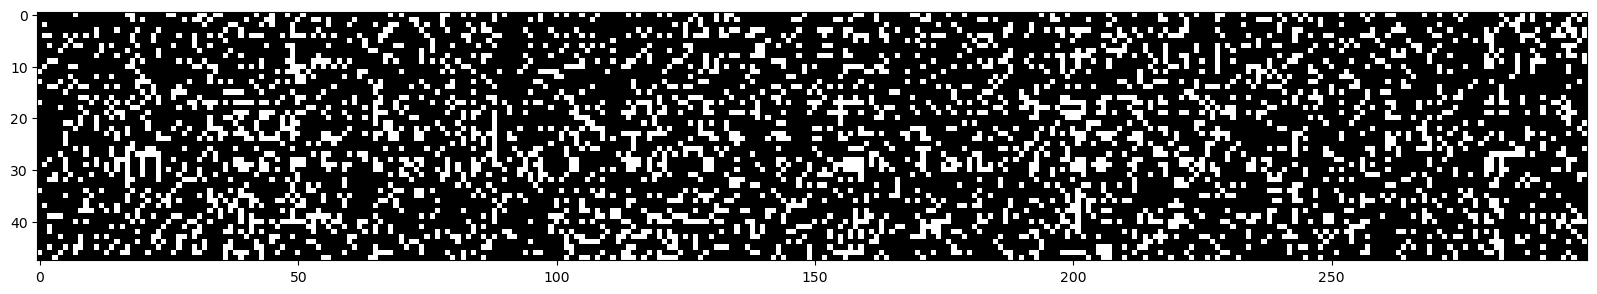

In [78]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation="nearest")

In [79]:

for p in parameters:
    p.requires_grad = False
    

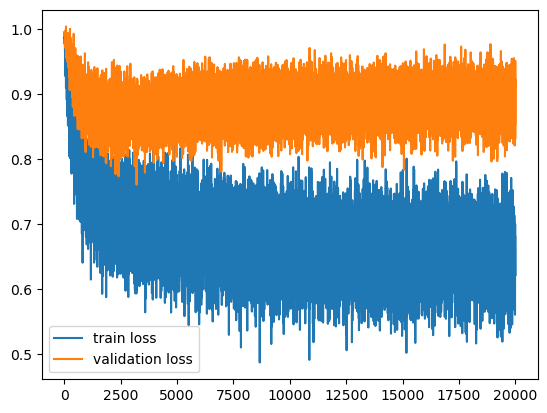

In [80]:
plt.plot(stepi, lossi,label = 'train loss')
plt.plot(stepi,val_lossi,label = 'validation loss')
plt.legend(loc=0) 

In [81]:
countiee=0

for _ in range(10):
    
    out = []
    gam = str(input())
    if gam not in mostchar.tolist():
        raise ValueError('Wrong Character')
    context = [0] * block_size # initialize with all ...
    context = context[1:] + [wi[gam]]
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    
    la=' '.join(iw[i] for i in out).strip("<>")
    print(la)
    


Michael
My teeming be a little ended that , I want to Jan vending . 
Pam
It 's why you always sit , wow here `` the last said good . 
Michael
Do trid . 
Jim
Well , you might to do has everyone it . Just Jamaica are ultra , right Victoria Calling . 
Andy
Hey , 're fine . 
Andy
You know what ? I see a lot Darryl ... cashier 's mafia Donna here item . 
Michael
And the last . 
Pam
You be be . The of , uh , eraser you have his . Halpert body who trapeze piranha 's hot it , specific ? I have done in our . 
Pam
That does n't make me to happen a lot times from the bathroom shredder an idea of words to EEEHHH the middle of good . 
Michael
It was Nightswept ? 
